## Example TU Wien Soil Moisture time series of stacked file

In this example we read and plot soil moisture time series using stacked files.

In [1]:
from veranda.io.stack import NcRasterStack
import xarray as xr
import netCDF4
import numpy as np

#For reading in filelist
import glob
import re
import pandas as pd
from datetime import datetime

#For timeseries plot
from equi7grid.equi7grid import Equi7Grid
import matplotlib.pyplot as plt

#For cartopy plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### With veranda

We can combine files or stacks into a single stack for time series plotting.

In [2]:
#set source directory
dir = ''#path to test data
input_path = dir+'*.nc'
output_path = dir+'stacked/'

#reads all files in input path, needed to stack by time
ds_ver = xr.open_mfdataset(input_path)

In [3]:
ds_ver

<xarray.Dataset>
Dimensions:                (time: 276, x: 1200, y: 1200)
Coordinates:
  * time                   (time) float64 4.388e+04 4.388e+04 ... 4.391e+04
  * y                      (y) float64 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
  * x                      (x) float64 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
Data variables:
    azimuthal_equidistant  (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    sm                     (time, y, x) float32 dask.array<chunksize=(4, 1200, 1200), meta=np.ndarray>
Attributes:
    created_with_software:  Python 3.6.12 and NetCDF 4.7.4
    processor_version:      WARP H NRT 1.1.1.post0.dev110+g3d58fca
    date_created:           2020-12-17 06:15:50
    id:                     H28_ASCAT_DIS_SSM_v2_E048N012T6_20200220_193150_M...
    sensor:                 ASCAT
    source_filename:        2020-02-20.nc
    platform:               Metop-A
    creater_url:            http://mrs.geo.tuwien.ac.at
    creater_email:          remote.sensing@geo.tuwien.ac.at
    creater_name:           TU Wien

In [3]:
#convert time to datetime
ds_ver['time'] = netCDF4.num2date(ds_ver['time'], "days since 1900-01-01 00:00:00",
                 only_use_cftime_datetimes=False)

In [5]:
#write stacked file to output directory
with NcRasterStack(mode='w') as stack:
    inventory = stack.write_netcdfs(ds_ver, output_path)

In [ ]:
with NcRasterStack(inventory=inventory) as stack:
    ts = stack.read(band='sm')

#### Alternative

In [4]:
def build_inventory(path,datetime_format):
        """
        Builds dataframe containing filenames and timestamps for h28 type files.
        
        Returns      
        -------      
        inventory : pandas.DataFrame 
            filenames and timestamps    
        
        """
        path_combined = path
        
        file_list = [file for file in glob.glob(path_combined+"/*.nc")]
        
        fname = file_list[0]
        match = re.search('\d{8}', fname).span()
        
        filename_datetime_format = (match[0], match[0]+15, datetime_format)
        ts_list = list()
        for f in file_list:
            
            ts = f[filename_datetime_format[0]:filename_datetime_format[1]]
            ts = datetime.strptime(ts, filename_datetime_format[2])
            ts_list.append(ts)
        
        inventory = pd.DataFrame(index=pd.DatetimeIndex(ts_list),
        columns=['filepath'],
        data=file_list)
        
        return inventory

In [5]:
#ALTERNATIVE working version, depends on build_inventory:


stack = NcRasterStack(mode='w')

datetime_format = "%Y%m%d_%H%M%S"
inventory = build_inventory(dir,datetime_format)
   
with NcRasterStack(inventory=inventory) as stack:
    ds_ver = stack.read(band='sm')
    
    
ds_ver = ds_ver.assign_coords({'time':ds_ver['time'].astype('datetime64[ns]')})
inventory = stack.write_netcdfs(ds_ver, output_path)

### Visualization

#### Time series plot

Plot soil moisture over time.

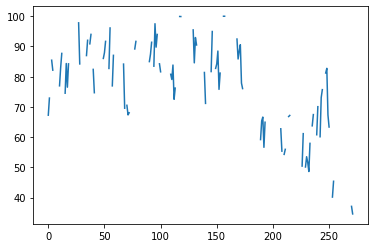

In [8]:
#define grid for plotting
e7_grid = Equi7Grid(500)

#location of sm source
lon,lat = 45.131913, 12.097916#44.5711, 11.5321
_, lon_i, lat_j = e7_grid.lonlat2ij_in_tile(lon, lat)

#or use index where max sm records not nan
sm_nan_sum = np.sum(~np.isnan(ds_ver['sm'].values),axis=0)
i,j = np.argwhere(sm_nan_sum==sm_nan_sum.max())[0]

 
#soil moisture time series
sm = ds_ver['sm'].values[:,i,j]

plt.plot(sm)

#### Plot map data

Plot soil moisture on a cartopy map.

In [12]:
def plot_map(img, extent, title='',vmin=None, vmax=None):
    # Equi7Grid - Europe
    central_meridian = 24.0
    latitude_of_origin = 53.0
    false_easting = 5837287.81977
    false_northing = 2121415.69617

    crs = ccrs.AzimuthalEquidistant(central_meridian, latitude_of_origin,
                                    false_easting, false_northing)

    fig = plt.figure(figsize=(14,12))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=crs, frameon=False)
    ax.patch.set_visible(False)
    ax.set_title(title)

    sc = ax.imshow(img, transform=crs, extent=extent,
                   vmin=vmin, vmax=vmax, origin='upper')

    ax.set_extent(extent, crs)

    countries_50m = cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '50m')
    ax.add_feature(countries_50m, facecolor='none', edgecolor='black')
    plt.colorbar(sc)

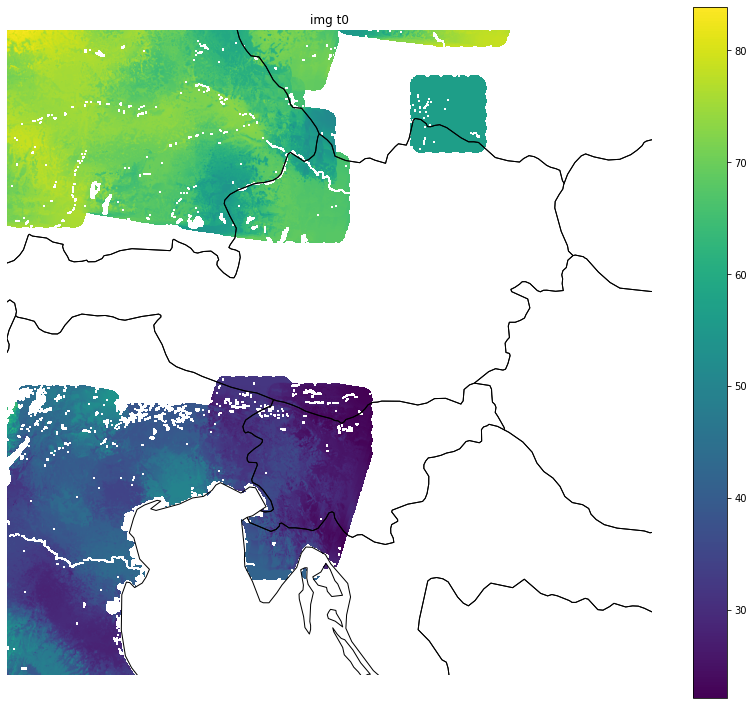

In [10]:
#define image source to be plotted
img = ds_ver['sm'].values[0,:,:]
title = 'img t0'

x = ds_ver.variables['x'][:]
y = ds_ver.variables['y'][:]
extent = [x.min(), x.max(), y.min(), y.max()]

plot_map(img, extent, title=title)

### With xarray

We can also read a single stack with xarray.

In [6]:
ds_xr = xr.open_mfdataset(input_path)

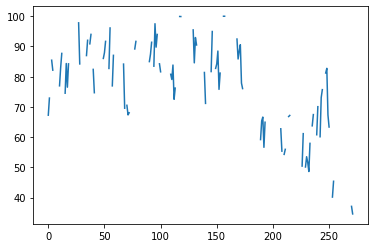

In [8]:
#define grid for plotting
e7_grid = Equi7Grid(500)

#location of sm source
lon,lat = 45.131913, 12.097916#44.5711, 11.5321
_, lon_i, lat_j = e7_grid.lonlat2ij_in_tile(lon, lat)

#or use index where max sm records not nan
sm_nan_sum = np.sum(~np.isnan(ds_ver['sm'].values),axis=0)
i,j = np.argwhere(sm_nan_sum==sm_nan_sum.max())[0]

#soil moisture time series
sm_xr = ds_xr['sm'].values[:,i,j]

plt.plot(sm_xr)

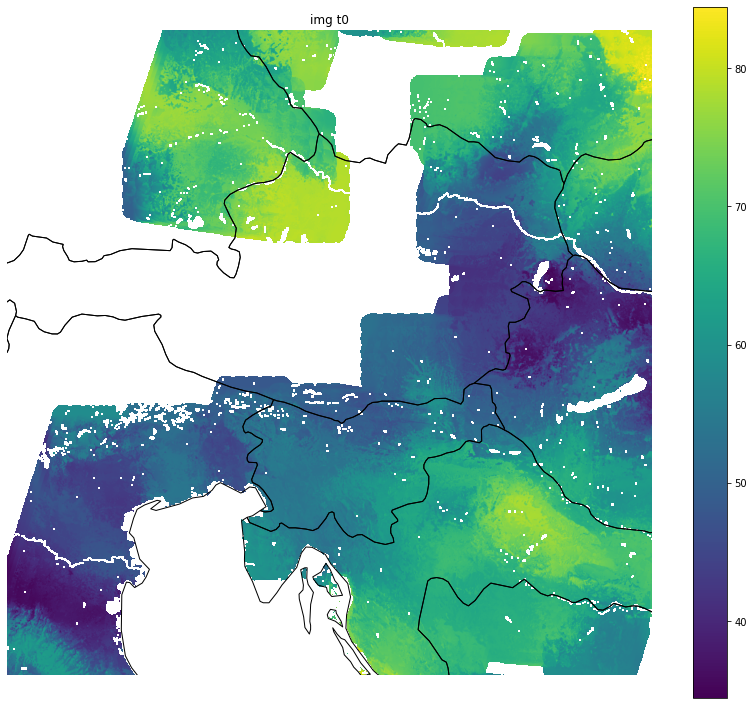

In [15]:
#define image source to be plotted
img = ds_xr['sm'].values[1,:,:]
title = 'img t0'

x = ds_xr.variables['x'][:]
y = ds_xr.variables['y'][:]
extent = [x.min(), x.max(), y.min(), y.max()]

plot_map(img, extent, title=title)